# <a href="http://www.datascience-paris-saclay.fr">Paris Saclay Center for Data Science</a>
## <a href=http://www.datascience-paris-saclay.fr/en/site/newsView/12>RAMP</a> on Pollenating Insects classification

<i> Balázs Kégl (CNRS), Romain Julliard (Muséum National d'Histoire Naturelle), Alex Gramfort (LTCI), Mehdi Cherti (CNRS) </i>

## Introduction

Pollenating insects play a fundamental role in the stability of ecosystems. An insect is said to be pollinator when it transports pollen from one flower to another, helping them to accomplish fertilization. The vast majority of plants pollenates using insects, and at the same time, these insects depend on plants for their survival. However, because of human intensified agrigulture, urbanisation and climate change, these species are threatened. 35% of human alimentation is based on plants pollenated by insects. Diversity of these insects is also important, the more diverse they are the best overall assistance is provided by these insects.

The SPIPOLL (Suivi Photographique des Insectes POLLinisateurs) project proposes to study quantitatively pollenating insects in France. For this, they created a crowdsourcing platform where anyone can upload pictures of insects and identify their species through a series of questions. These data are then used by specialists for further analyses.

Reference : http://www.spipoll.org/

## Data

In this RAMP, we propose a dataset of pictures of insects from different species gathered from the SPIPOLL project and labeled by specialists. The dataset contains a set of 20348 labeled pictures of insects, there are 18 different classes each one corresponding to a different insect specie. Each picture is a 64x64 colored image, which makes a total of $64 \times 64 \times 3=12288$ features per picture.

## The prediction task

The goal of this RAMP is to classify correctly the species of the insects. For each submission, you will have to provide a classifier, which will fit a training set and predict the classes (species) on a test set.

# Exploratory data analysis

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
pd.options.display.max_rows = 20
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

In [2]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [2]:
data = np.load("train_64x64.npz")

In [3]:
X, y = data['X'], data['y']

In [4]:
X.shape

(20348, 64, 64, 3)

Let's look first at the distribution of of the pixel intensities for each color separately

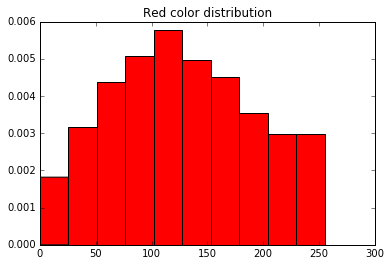

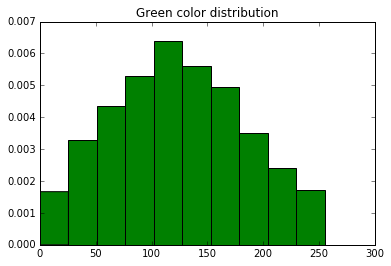

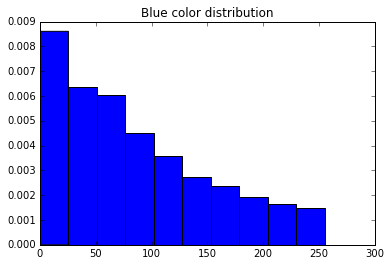

In [5]:
colors = dict(R=0, G=1, B=2)
subsample = np.random.choice(np.arange(X.shape[0]), replace=False, size=500)
plt.hist(X[subsample, :, :, colors["R"]].flatten(), color="red", normed=True)
plt.title("Red color distribution")
plt.show()
plt.hist(X[subsample, :, :, colors["G"]].flatten(), color="green", normed=True)
plt.title("Green color distribution")
plt.show()
plt.hist(X[subsample, :, :, colors["B"]].flatten(), color="blue", normed=True)
plt.title("Blue color distribution")
plt.show()

Let's now look at the distribution of the labels. The labels given are taxon ids, not strings, but we can convert them to strings to know for which species they refer to, we will see that later.

In [6]:
y.shape

(20348,)

In [7]:
pd.Series(y)

0         715
1         978
2         970
3         715
4         565
5         687
6         687
7         952
8         565
9         970
         ... 
20338     565
20339     565
20340     996
20341    1071
20342     565
20343     715
20344     565
20345    1071
20346     970
20347     565
dtype: int64

In [8]:
pd.Series(y).unique()

array([ 715,  978,  970,  565,  687,  952, 1061, 1071,  682,  833,  995,
        696,  971,  835,  996,  654,  759,  881])

Now, let's see for which species these taxon ids refer to.

We first load <code>taxon_id_to_french_names</code> a file which contains
the mapping between taxon ids and species names.

In [9]:
labels = pd.read_table("taxon_id_to_french_names.txt", sep="\s{2,}", 
                       names=["name", "taxon_id"], 
                       index_col="taxon_id")
labels

/home/ubuntu/miniconda2/envs/databoard-env/lib/python2.7/site-packages/ipykernel/__main__.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  app.launch_new_instance()


,name
taxon_id,
565,L'Abeille mellifère <Apis mellifera>
952,L'Araignée crabe Napoléon <Synema globosum>
682,L'Eristale des fleurs <Myathropa florea>
978,La Coccinelle à 7 points <Coccinella septempun...
835,Le Drap mortuaire <Oxythyrea funesta>
759,Le Pentatome rayé <Graphosoma lineatum>
715,Le Syrphe ceinturé <Episyrphus balteatus>
1061,"Les Araignées crabes sombres <Xysticus, Coriar..."
970,Les Bourdons noirs à bande(s) jaune(s) et cul ...


Then we perform the mapping to get labels of the examples but with strings.

In [10]:
y_names = pd.Series(y).map(labels["name"].to_dict())
y_names

0                Le Syrphe ceinturé <Episyrphus balteatus>
1        La Coccinelle à 7 points <Coccinella septempun...
2        Les Bourdons noirs à bande(s) jaune(s) et cul ...
3                Le Syrphe ceinturé <Episyrphus balteatus>
4                     L'Abeille mellifère <Apis mellifera>
5               Les Hélophiles <Helophilus, Parhelophilus>
6               Les Hélophiles <Helophilus, Parhelophilus>
7              L'Araignée crabe Napoléon <Synema globosum>
8                     L'Abeille mellifère <Apis mellifera>
9        Les Bourdons noirs à bande(s) jaune(s) et cul ...
                               ...                        
20338                 L'Abeille mellifère <Apis mellifera>
20339                 L'Abeille mellifère <Apis mellifera>
20340                       Les Guêpes Polistes <Polistes>
20341    Les Cétoines métalliques à marques blanches <C...
20342                 L'Abeille mellifère <Apis mellifera>
20343            Le Syrphe ceinturé <Episyrphus balteatu

The number of examples per specie is:

In [11]:
y_names.groupby(y_names.values).size().sort(inplace=False, ascending=False)

/home/ubuntu/miniconda2/envs/databoard-env/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  if __name__ == '__main__':


L'Abeille mellifère <Apis mellifera>                                        5881
Les Bourdons noirs à bande(s) jaune(s) et cul blanc <Bombus>                3154
Le Syrphe ceinturé <Episyrphus balteatus>                                   1725
Les Mouches aux reflets métalliques <Neomyia, Calliphora et autres>         1140
Les Guêpes Polistes <Polistes>                                              1051
Les Bourdons noirs à bande(s) jaune(s) et cul rouge <Bombus>                 930
La Coccinelle à 7 points <Coccinella septempunctata>                         854
Les Guêpes Crabronidae difficiles à déterminer <Crabronidae>                 712
L'Araignée crabe Napoléon <Synema globosum>                                  661
Les Hélophiles <Helophilus, Parhelophilus>                                   618
L'Eristale des fleurs <Myathropa florea>                                     590
Les Cétoines métalliques à marques blanches <Cetonia, Protaetia>             576
Les Xylocopes <Xylocopa>    

/home/ubuntu/miniconda2/envs/databoard-env/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  if __name__ == '__main__':


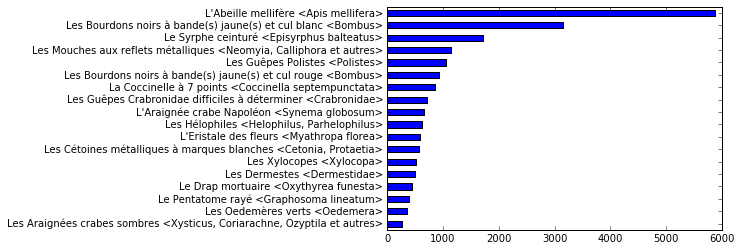

In [12]:
y_names.groupby(y_names.values).size().sort(inplace=False).plot(kind='barh');

Let's now look at the images:

Specie : name    Les Bourdons noirs à bande(s) jaune(s) et cul ...
Name: 970, dtype: object


/home/ubuntu/miniconda2/envs/databoard-env/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


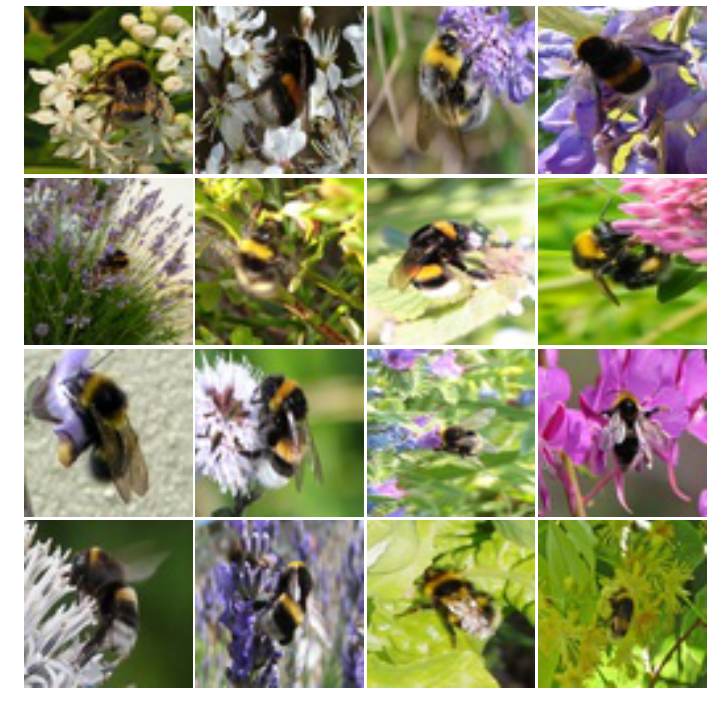

In [13]:
nb_rows = 4
nb_cols = 4
nb_elements = nb_rows * nb_cols
class_id = 970

print("Specie : {0}".format(labels.loc[class_id]))

X_given_class_id = X[y==class_id]

subsample = np.random.choice(np.arange(X_given_class_id.shape[0]), replace=False, size=nb_elements)

fig = plt.figure(figsize=(10, 10))
grid = AxesGrid(fig, 111, # similar to subplot(141)
                nrows_ncols = (nb_rows, nb_cols),
                axes_pad = 0.05,
                label_mode = "1",
)
for i, image_index in enumerate(subsample):
    im = grid[i].imshow(X_given_class_id[i, :, :]/255.)
    grid[i].axis('off')
plt.tight_layout()

## The pipeline

In [14]:
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.cross_validation import cross_val_score

As said earlier, the goal of this RAMP is to classify correctly the species of the insects. For each submission, you will have to provide a Classifier class, following [scikit-learn](scikit-learn.org) convention. 

Let's start by a simple **random forest** classifier, as an example.

In [15]:
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier
 
class Classifier(BaseEstimator):
    
    def __init__(self):
        pass

    def fit(self, X, y):
        X_vectorized = X.reshape((X.shape[0], X.shape[1] * X.shape[2] * X.shape[3]))    
        self.clf = RandomForestClassifier(
            n_estimators=10, max_features=2, max_leaf_nodes=5)
        self.clf.fit(X_vectorized, y)
 
    def predict(self, X):
        X_vectorized = X.reshape((X.shape[0], X.shape[1] * X.shape[2] * X.shape[3]))    
        return self.clf.predict(X_vectorized)
 
    def predict_proba(self, X):
        X_vectorized = X.reshape((X.shape[0], X.shape[1] * X.shape[2] * X.shape[3]))    
        return self.clf.predict_proba(X_vectorized)

### Unit test

In [16]:
def unit_test(classifier, nb_iter=5):
    test_size = 0.2
    random_state = 15
    cv = StratifiedShuffleSplit(y, nb_iter,
                                test_size=test_size,
                                random_state=random_state)
    clf = classifier()
    scores = cross_val_score(clf, X=X, y=y, scoring='accuracy', cv=cv)
    return scores

In [17]:
print(unit_test(Classifier))

[ 0.29080629  0.28982301  0.29080629  0.2920354   0.29031465]


Let's now try a vanilla **feedforward neural net**.

In [18]:
import os
os.environ["THEANO_FLAGS"] = "device=gpu"
from sklearn.base import BaseEstimator
import os
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.layers import Input, Dense, Flatten
from keras.models import Model
from keras.optimizers import RMSprop
from keras.utils import np_utils
from keras.callbacks import EarlyStopping

def build_model():
    
    inp = Input(shape=(64 * 64 * 3,))
    h1 = Dense(500, activation='relu')(inp)
    h2 = Dense(500, activation='relu')(h1)
    out = Dense(18, activation='softmax')(h2)
    
    model = Model(input=inp, output=out)
    optimizer = RMSprop(lr=0.001)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

class Classifier(BaseEstimator):
    
    def __init__(self):
        self.model = build_model()
        self.label_encoder = None

    def fit(self, X, y):
        X = self.preprocess_X(X)
        y = self.preprocess_y(y)
        self.model.fit(X, y, verbose=1, 
                       validation_split=0.2,
                       callbacks=[EarlyStopping(monitor='val_acc', patience=10, verbose=1, mode='max')],
                       nb_epoch=30)
        return self

    def predict(self, X):
        X = self.preprocess_X(X)
        y = self.model.predict(X).argmax(axis=1)
        y = self.deprocess_y(y)
        return y

    def preprocess_X(self, X):
        X = X.reshape((X.shape[0], X.shape[1] * X.shape[2] * X.shape[3])) # flatten images to vectors
        X = X / 255.
        return X
    
    def preprocess_y(self, y):
        if self.label_encoder is None:
            self.label_encoder = LabelEncoder()
            self.label_encoder.fit(y)
        y = self.label_encoder.transform(y)
        y = np_utils.to_categorical(y)
        return y
    
    def deprocess_y(self, y):
        return self.label_encoder.inverse_transform(y)
            
classifier = build_model()

Using Theano backend.
Using gpu device 0: GRID K520 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/build/Theano/theano/sandbox/cuda/__init__.py:599: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


On machines without GPUs this will take a while. 

In [19]:
print(unit_test(Classifier))

Train on 13024 samples, validate on 3256 samples
Epoch 1/30
13024/13024 [==============================] - 5s - loss: 13.4853 - acc: 0.1614 - val_loss: 13.5440 - val_acc: 0.1597
Epoch 2/30
13024/13024 [==============================] - 5s - loss: 13.6392 - acc: 0.1538 - val_loss: 13.5440 - val_acc: 0.1597
Epoch 3/30
13024/13024 [==============================] - 5s - loss: 13.6392 - acc: 0.1538 - val_loss: 13.5440 - val_acc: 0.1597
Epoch 4/30
13024/13024 [==============================] - 5s - loss: 13.6392 - acc: 0.1538 - val_loss: 13.5440 - val_acc: 0.1597
Epoch 5/30
13024/13024 [==============================] - 5s - loss: 13.6392 - acc: 0.1538 - val_loss: 13.5440 - val_acc: 0.1597
Epoch 6/30
13024/13024 [==============================] - 5s - loss: 13.6392 - acc: 0.1538 - val_loss: 13.5440 - val_acc: 0.1597
Epoch 7/30
 4640/13024 [=========>....................] - ETA: 3s - loss: 13.7594 - acc: 0.1463

KeyboardInterrupt: 

Finally, let's try a basic **convolutional neural net**:

In [21]:
import os
os.environ["THEANO_FLAGS"] = "device=gpu"
from sklearn.base import BaseEstimator
import os
import numpy as np

from keras.layers import Convolution2D, MaxPooling2D
from keras.callbacks import EarlyStopping

def build_model():
    
    inp = Input(shape=(3, 64, 64))
    c1 = Convolution2D(16, 3, 3, activation='relu')(inp)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Convolution2D(32, 3, 3, activation='relu')(p1)
    p2 = MaxPooling2D((2, 2))(c2)
    c3 = Convolution2D(32, 3, 3, activation='relu')(p2)
    p3 = MaxPooling2D((2, 2))(c3)
    fc1 = Dense(100, activation='relu')(Flatten()(p3))
    fc2 = Dense(100, activation='relu')(fc1)
    out = Dense(18, activation='softmax')(fc2)

    model = Model(input=inp, output=out)
    optimizer = RMSprop(lr=0.001)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


class Classifier(BaseEstimator):
    
    def __init__(self):
        self.model = build_model()
        self.label_encoder = None

    def fit(self, X, y):
        X = self.preprocess_X(X)
        y = self.preprocess_y(y)
        self.model.fit(X, y, verbose=1, 
                       validation_split=0.2,
                       callbacks=[EarlyStopping(monitor='val_acc', patience=10, verbose=1, mode='max')],
                       nb_epoch=30)
        return self

    def predict(self, X):
        X = self.preprocess_X(X)
        y = self.model.predict(X).argmax(axis=1)
        y = self.deprocess_y(y)
        return y

    def preprocess_X(self, X):
        X = X.transpose((0, 3, 1, 2)) # make color channel as second dimesion
        X = X / 255.
        return X
    
    def preprocess_y(self, y):
        if self.label_encoder is None:
            self.label_encoder = LabelEncoder()
            self.label_encoder.fit(y)
        y = self.label_encoder.transform(y)
        y = np_utils.to_categorical(y)
        return y
    
    def deprocess_y(self, y):
        return self.label_encoder.inverse_transform(y)

Don't run the following cell at home. If the classical neural net was slow, this will never terminate unless you run it on a GPU. 

In [ ]:
print(unit_test(Classifier))

Train on 13024 samples, validate on 3256 samples
Epoch 1/30


In [ ]:
!nvidia-smi

## Submission

For submitting your code, first create a github repo and enter its public address (https://...) at the submission site. Place your to file <code>classifier.py</code> in the git repo, and then run the following sequence.

<code>
git add classifier.py
git commit -m "my commit log"
git tag model_description
git push origin master --tags
</code>

We will fetch your submission. At this point it will appear in the "New models" table. Once it is trained, it will either be added to the leaderboards, or it will appear in the "Failed models" table. Clicking on “error” will bring you to the error that python threw.

### Deleting failed models

You cannot delete models once they appear in the leaderboard. However, you can delete failed models by executing the following sequence:

<code>
git tag -d model_description
git push origin :refs/tags/model_description
</code>

The first command deletes your local tag and the second command deletes the remote tag. When we fetch next time, the model will disappear from the table. You can then reuse the tag to resubmit another model.